In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np

from scipy.stats import spearmanr, kendalltau

from einops import rearrange

import torch

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [2]:
ckpt = "/data/scratch/twhit/checkpoints/trained_encoder_dc2.ckpt"

with initialize(config_path="../../", version_base=None):
    cfg = compose("config_dc2", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed

Seed set to 123123


Configure the test dataloader:

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

Load in encoder weights:

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

Store true and posterior mode shear and convergence for the test images:

In [5]:
shear1_true = torch.zeros(len(test_dl), 8, 8, device=device)
shear1_pred = torch.zeros(len(test_dl), 8, 8, device=device)
shear1_baseline = torch.zeros(len(test_dl), 8, 8, device=device)
shear2_true = torch.zeros(len(test_dl), 8, 8, device=device)
shear2_pred = torch.zeros(len(test_dl), 8, 8, device=device)
shear2_baseline = torch.zeros(len(test_dl), 8, 8, device=device)
convergence_true = torch.zeros(len(test_dl), 8, 8, device=device)
convergence_pred = torch.zeros(len(test_dl), 8, 8, device=device)
ra = torch.zeros(len(test_dl), 8, 8, device=device)
dec = torch.zeros(len(test_dl), 8, 8, device=device)
test_loss = torch.zeros(len(test_dl), device = device)

i = -1
for b in test_dl:
    i += 1
    batch = move_data_to_device(b, device)
    
    shear1_true[i] = batch['tile_catalog']['shear_1'].squeeze().flip(dims=[0,1])
    shear2_true[i] = batch['tile_catalog']['shear_2'].squeeze().flip(dims=[0,1])
    convergence_true[i] = batch['tile_catalog']['convergence'].squeeze().flip(dims=[0,1])
    ra[i] = batch['tile_catalog']['ra'].squeeze().flip(dims=[0,1])
    dec[i] = batch['tile_catalog']['dec'].squeeze().flip(dims=[0,1])
    
    with torch.no_grad():
        mode_cat = encoder.sample(batch, use_mode=True)
        test_loss[i] = encoder._compute_loss(batch, None)
    
    shear1_pred[i] = mode_cat['shear_1'].squeeze().flip(dims=[0,1])
    shear1_baseline[i] = batch['tile_catalog']['ellip_lsst_wavg'][...,0].squeeze().flip(dims=[0,1])
    shear2_pred[i] = mode_cat['shear_2'].squeeze().flip(dims=[0,1])
    shear2_baseline[i] = batch['tile_catalog']['ellip_lsst_wavg'][...,1].squeeze().flip(dims=[0,1])
    convergence_pred[i] = mode_cat['convergence'].squeeze().flip(dims=[0,1])

/home/twhit/bliss/.venv/lib/python3.10/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Compute test MSEs:

In [6]:
print(f'shear 1 test MSE (BLISS) = {((shear1_true - shear1_pred) ** 2).mean()}')
print(f'shear 1 test MSE (baseline) = {((shear1_true - shear1_baseline) ** 2).mean()}')
print(f'shear 2 test MSE (BLISS) = {((shear2_true - shear2_pred) ** 2).mean()}')
print(f'shear 2 test MSE (baseline) = {((shear2_true - shear2_baseline) ** 2).mean()}')
print(f'convergence test MSE = {((convergence_true - convergence_pred) ** 2).mean()}')

shear 1 test MSE (BLISS) = 4.920887295156717e-05
shear 1 test MSE (baseline) = 7.549726433353499e-05
shear 2 test MSE (BLISS) = 5.72199460293632e-05
shear 2 test MSE (baseline) = 6.856612162664533e-05
convergence test MSE = 6.227481935638934e-05


Compute Pearson correlation coefficients:

In [7]:
print(f'shear 1 pearson correlation (BLISS) = {np.corrcoef(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[1,0]}')
print(f'shear 1 pearson correlation (baseline) = {np.corrcoef(shear1_true.flatten().cpu(), shear1_baseline.flatten().cpu())[1,0]}')
print(f'shear 2 pearson correlation (BLISS) = {np.corrcoef(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[1,0]}')
print(f'shear 2 pearson correlation (baseline) = {np.corrcoef(shear2_true.flatten().cpu(), shear2_baseline.flatten().cpu())[1,0]}')
print(f'convergence pearson correlation = {np.corrcoef(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu())[1,0]}')

shear 1 pearson correlation (BLISS) = 0.435637989349972
shear 1 pearson correlation (baseline) = -0.26332237962384103
shear 2 pearson correlation (BLISS) = 0.44403819804396005
shear 2 pearson correlation (baseline) = 0.11040594191478201
convergence pearson correlation = 0.7548293892558873


Compute Spearman correlation coefficients:

In [8]:
print(f'shear 1 spearman correlation (BLISS) = {spearmanr(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[0]}')
print(f'shear 1 spearman correlation (baseline) = {spearmanr(shear1_true.flatten().cpu(), shear1_baseline.flatten().cpu())[0]}')
print(f'shear 2 spearman correlation (BLISS) = {spearmanr(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[0]}')
print(f'shear 2 spearman correlation (baseline) = {spearmanr(shear2_true.flatten().cpu(), shear2_baseline.flatten().cpu())[0]}')
print(f'convergence spearman correlation = {spearmanr(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu())[0]}')

shear 1 spearman correlation (BLISS) = 0.4060353264849011
shear 1 spearman correlation (baseline) = -0.24783600201965358
shear 2 spearman correlation (BLISS) = 0.4087877221751875
shear 2 spearman correlation (baseline) = 0.15728259272070438
convergence spearman correlation = 0.7495087930399609


Compute Kendall correlation coefficients:

In [9]:
print(f'shear 1 kendall correlation (BLISS) = {kendalltau(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[0]}')
print(f'shear 1 kendall correlation (baseline) = {kendalltau(shear1_true.flatten().cpu(), shear1_baseline.flatten().cpu())[0]}')
print(f'shear 2 kendall correlation (BLISS) = {kendalltau(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[0]}')
print(f'shear 2 kendall correlation (baseline) = {kendalltau(shear2_true.flatten().cpu(), shear2_baseline.flatten().cpu())[0]}')
print(f'convergence kendall correlation = {kendalltau(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu())[0]}')

shear 1 kendall correlation (BLISS) = 0.27988889682704393
shear 1 kendall correlation (baseline) = -0.16645296014067995
shear 2 kendall correlation (BLISS) = 0.28336874505151477
shear 2 kendall correlation (baseline) = 0.10161227860191456
convergence kendall correlation = 0.556913170322282


Compute test loss:

In [10]:
print(f'test loss = {test_loss.mean()}')

test loss = -10.49278450012207


Scatterplots of true vs. posterior mode shear and convergence:

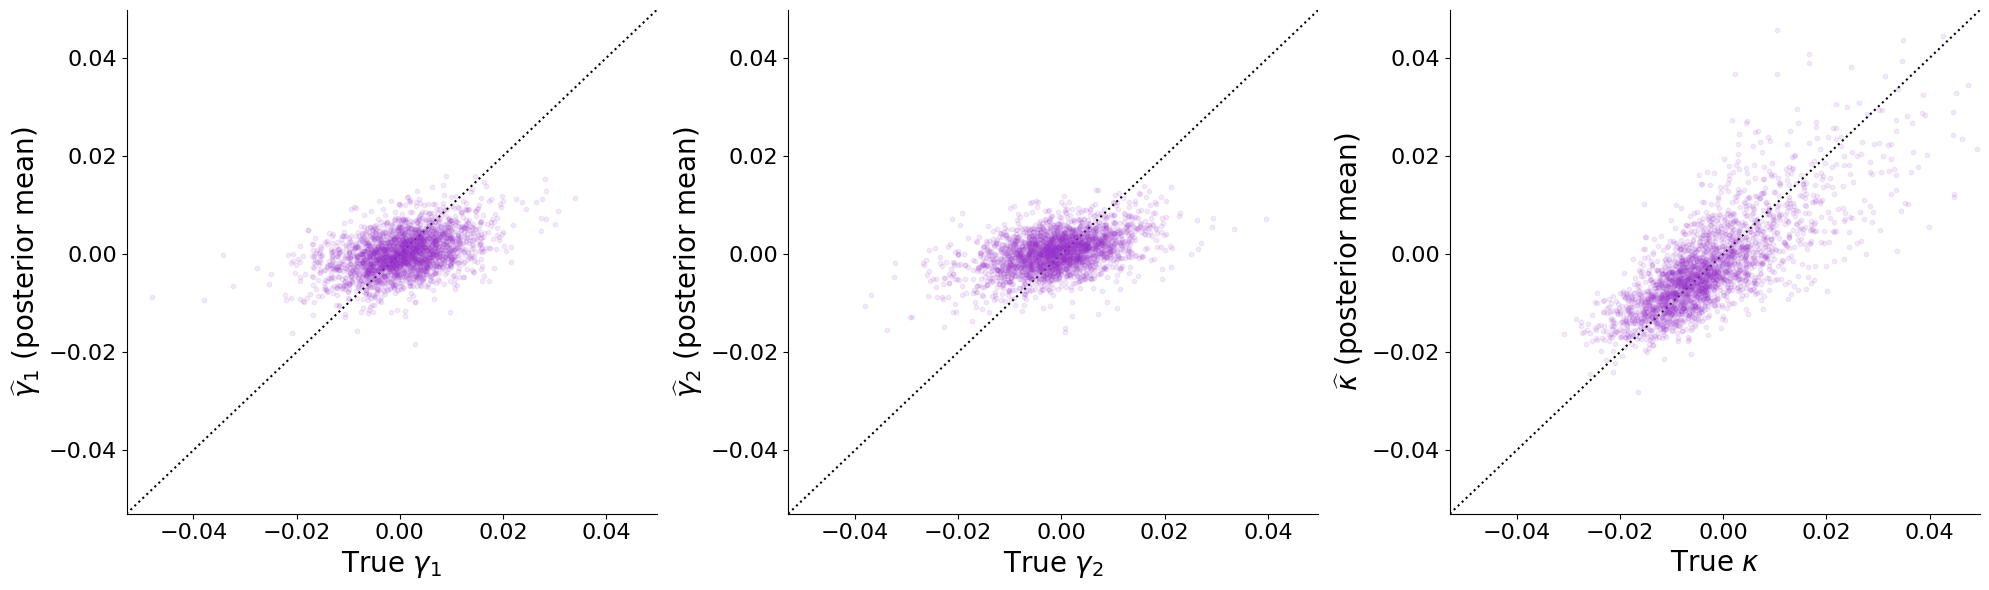

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
alpha = 0.1
s = 10
fontsize = 20
ticklabelsize = 16
bliss_color = 'darkorchid'
baseline_color = 'sienna'
axmin = min(shear1_true.min(), shear2_true.min(), shear1_pred.min(), shear2_pred.min(), shear1_baseline.min(), shear2_baseline.min(), convergence_true.min(), convergence_pred.min()).cpu() - 0.005
axmax = max(shear1_true.max(), shear2_true.max(), shear1_pred.max(), shear2_pred.max(), shear1_baseline.max(), shear2_baseline.max(), convergence_true.quantile(0.995), convergence_pred.quantile(0.995)).cpu() + 0.005

_ = ax[0].scatter(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[0].set_xlabel(r'True $\gamma_1$', fontsize = fontsize)
_ = ax[0].set_ylabel(r'$\widehat{\gamma}_1$ (posterior mean)', fontsize = fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))
_ = ax[0].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

_ = ax[1].scatter(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[1].set_xlabel(r'True $\gamma_2$', fontsize = fontsize)
_ = ax[1].set_ylabel(r'$\widehat{\gamma}_2$ (posterior mean)', fontsize = fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))
_ = ax[1].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

_ = ax[2].scatter(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[2].set_xlabel(r'True $\kappa$', fontsize = fontsize)
_ = ax[2].set_ylabel(r'$\widehat{\kappa}$ (posterior mean)', fontsize = fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xlim((axmin, axmax))
_ = ax[2].set_ylim((axmin, axmax))
_ = ax[2].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

fig.savefig("figures/scatterplots.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

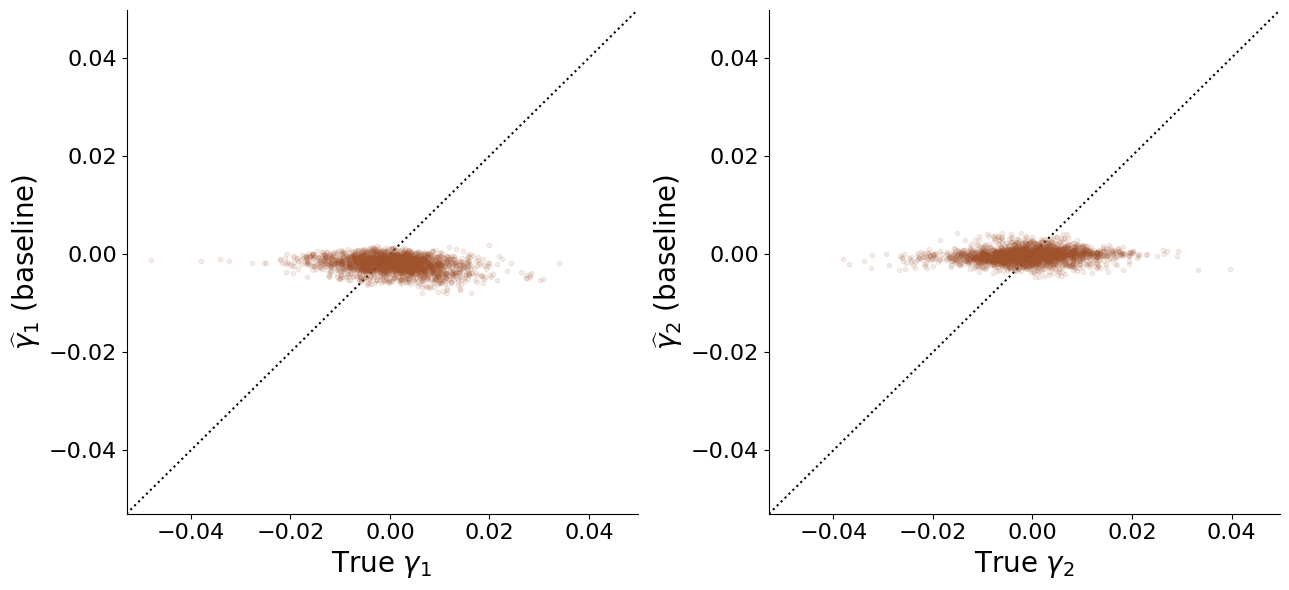

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
axmin = min(shear1_true.min(), shear2_true.min(), shear1_baseline.min(), shear2_baseline.min(), convergence_true.min(), convergence_pred.min()).cpu() - 0.005
axmax = max(shear1_true.max(), shear2_true.max(), shear1_baseline.max(), shear2_baseline.max(), convergence_true.quantile(0.995), convergence_pred.quantile(0.995)).cpu() + 0.005

_ = ax[0].scatter(shear1_true.flatten().cpu(), shear1_baseline.flatten().cpu(),
                  color = baseline_color, alpha = alpha, s = s, zorder = 1)
_ = ax[0].set_xlabel(r'True $\gamma_1$', fontsize = fontsize)
_ = ax[0].set_ylabel(r'$\widehat{\gamma}_1$ (baseline)', fontsize = fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))
_ = ax[0].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

_ = ax[1].scatter(shear2_true.flatten().cpu(), shear2_baseline.flatten().cpu(),
                  color = baseline_color, alpha = alpha, s = s, zorder = 1)
_ = ax[1].set_xlabel(r'True $\gamma_2$', fontsize = fontsize)
_ = ax[1].set_ylabel(r'$\widehat{\gamma}_2$ (baseline)', fontsize = fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))
_ = ax[1].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)
    
fig.tight_layout()

fig.savefig("figures/scatterplots_baseline.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Posterior mean shear and convergence maps for a few images:

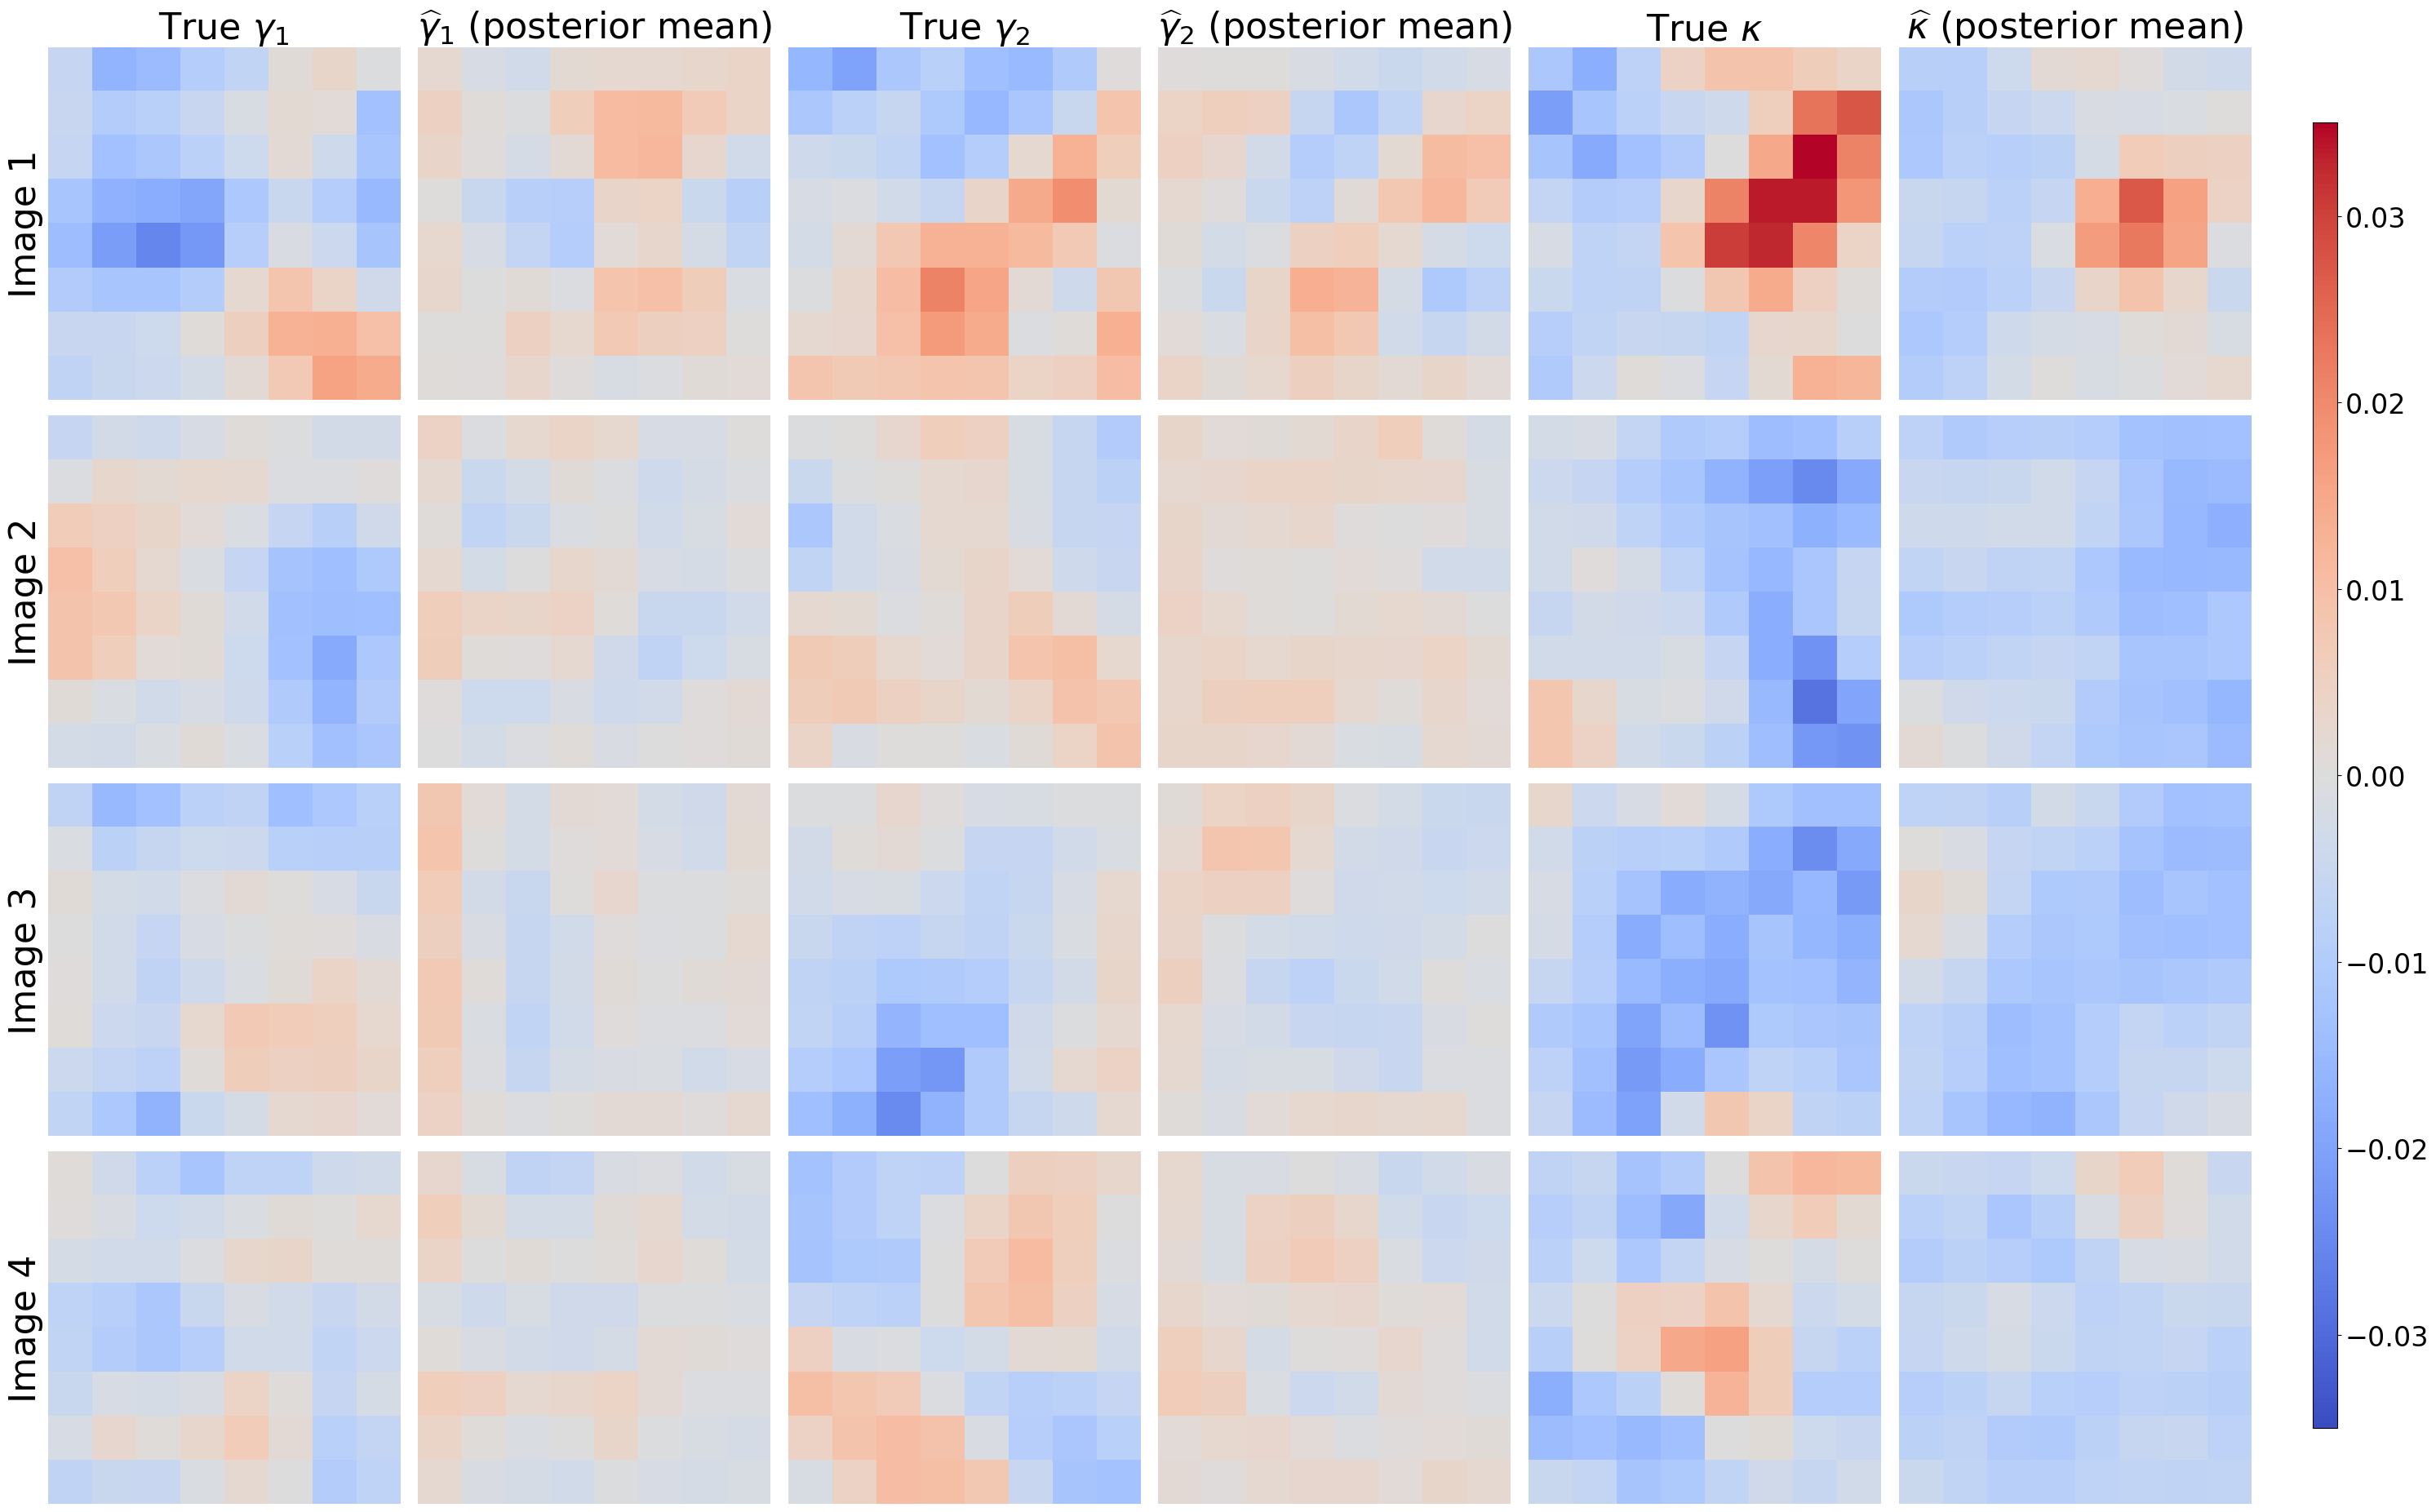

In [13]:
num_maps = 4
fig, ax = plt.subplots(num_maps, 6, figsize = (30, 5*num_maps))
fontsize = 32
cmap = 'coolwarm'
vmin = -0.035
vmax = 0.035

for i in range(num_maps):
    _ = ax[i,0].imshow(shear1_true[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,0].set_title(r'True $\gamma_1$', fontsize = fontsize)
    _ = ax[i,0].set_xticks([])
    _ = ax[i,0].set_yticks([])
    _ = ax[i,0].set_ylabel(f'Image {i+1}', fontsize = fontsize)
    _ = ax[i,1].imshow(shear1_pred[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,1].set_title(r'$\widehat{\gamma}_1$ (posterior mean)', fontsize = fontsize)
    _ = ax[i,1].set_xticks([])
    _ = ax[i,1].set_yticks([])
    
    _ = ax[i,2].imshow(shear2_true[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,2].set_title(r'True $\gamma_2$', fontsize = fontsize)
    _ = ax[i,2].set_xticks([])
    _ = ax[i,2].set_yticks([])
    _ = ax[i,3].imshow(shear2_pred[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,3].set_title(r'$\widehat{\gamma}_2$ (posterior mean)', fontsize = fontsize)
    _ = ax[i,3].set_xticks([])
    _ = ax[i,3].set_yticks([])
    
    _ = ax[i,4].imshow(convergence_true[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,4].set_title(r'True $\kappa$', fontsize = fontsize)
    _ = ax[i,4].set_xticks([])
    _ = ax[i,4].set_yticks([])
    conv = ax[i,5].imshow(convergence_pred[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,5].set_title(r'$\widehat{\kappa}$ (posterior mean)', fontsize = fontsize)
    _ = ax[i,5].set_xticks([])
    _ = ax[i,5].set_yticks([])

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.1, 0.01, 0.8])
cbar_ax.tick_params(labelsize = 0.75*fontsize)
fig.colorbar(conv, cax=cbar_ax)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.01)

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/posteriormeanmaps_images.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Posterior mean shear and convergence maps for the entire test set:

In [14]:
mask = (dec > -36.4).all([-1,-2])
ra_subset = ra[mask]
dec_subset = dec[mask]
shear1_true_subset = shear1_true[mask]
shear1_pred_subset = shear1_pred[mask]
shear2_true_subset = shear2_true[mask]
shear2_pred_subset = shear2_pred[mask]
convergence_true_subset = convergence_true[mask]
convergence_pred_subset = convergence_pred[mask]

In [15]:
ra_mean = ra_subset.mean([-1,-2])
dec_mean = dec_subset.mean([-1,-2])
radec_mean = torch.stack((ra_mean, dec_mean), dim=-1)
sorted_indices = torch.argsort(- radec_mean[:,1] * 1e5 + radec_mean[:,0])

In [16]:
ra_subset_sorted = rearrange(ra_subset[sorted_indices].view(6,4,8,8), "h w nh nw -> (h nh) (w nw)")
dec_subset_sorted = rearrange(dec_subset[sorted_indices].view(6,4,8,8), "h w nh nw -> (h nh) (w nw)")
shear1_true_subset_sorted = rearrange(shear1_true_subset[sorted_indices].view(6,4,8,8), "h w nh nw -> (h nh) (w nw)")
shear1_pred_subset_sorted = rearrange(shear1_pred_subset[sorted_indices].view(6,4,8,8), "h w nh nw -> (h nh) (w nw)")
shear2_true_subset_sorted = rearrange(shear2_true_subset[sorted_indices].view(6,4,8,8), "h w nh nw -> (h nh) (w nw)")
shear2_pred_subset_sorted = rearrange(shear2_pred_subset[sorted_indices].view(6,4,8,8), "h w nh nw -> (h nh) (w nw)")
convergence_true_subset_sorted = rearrange(convergence_true_subset[sorted_indices].view(6,4,8,8), "h w nh nw -> (h nh) (w nw)")
convergence_pred_subset_sorted = rearrange(convergence_pred_subset[sorted_indices].view(6,4,8,8), "h w nh nw -> (h nh) (w nw)")

/tmp/ipykernel_1208923/128387844.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  _ = fig.tight_layout()


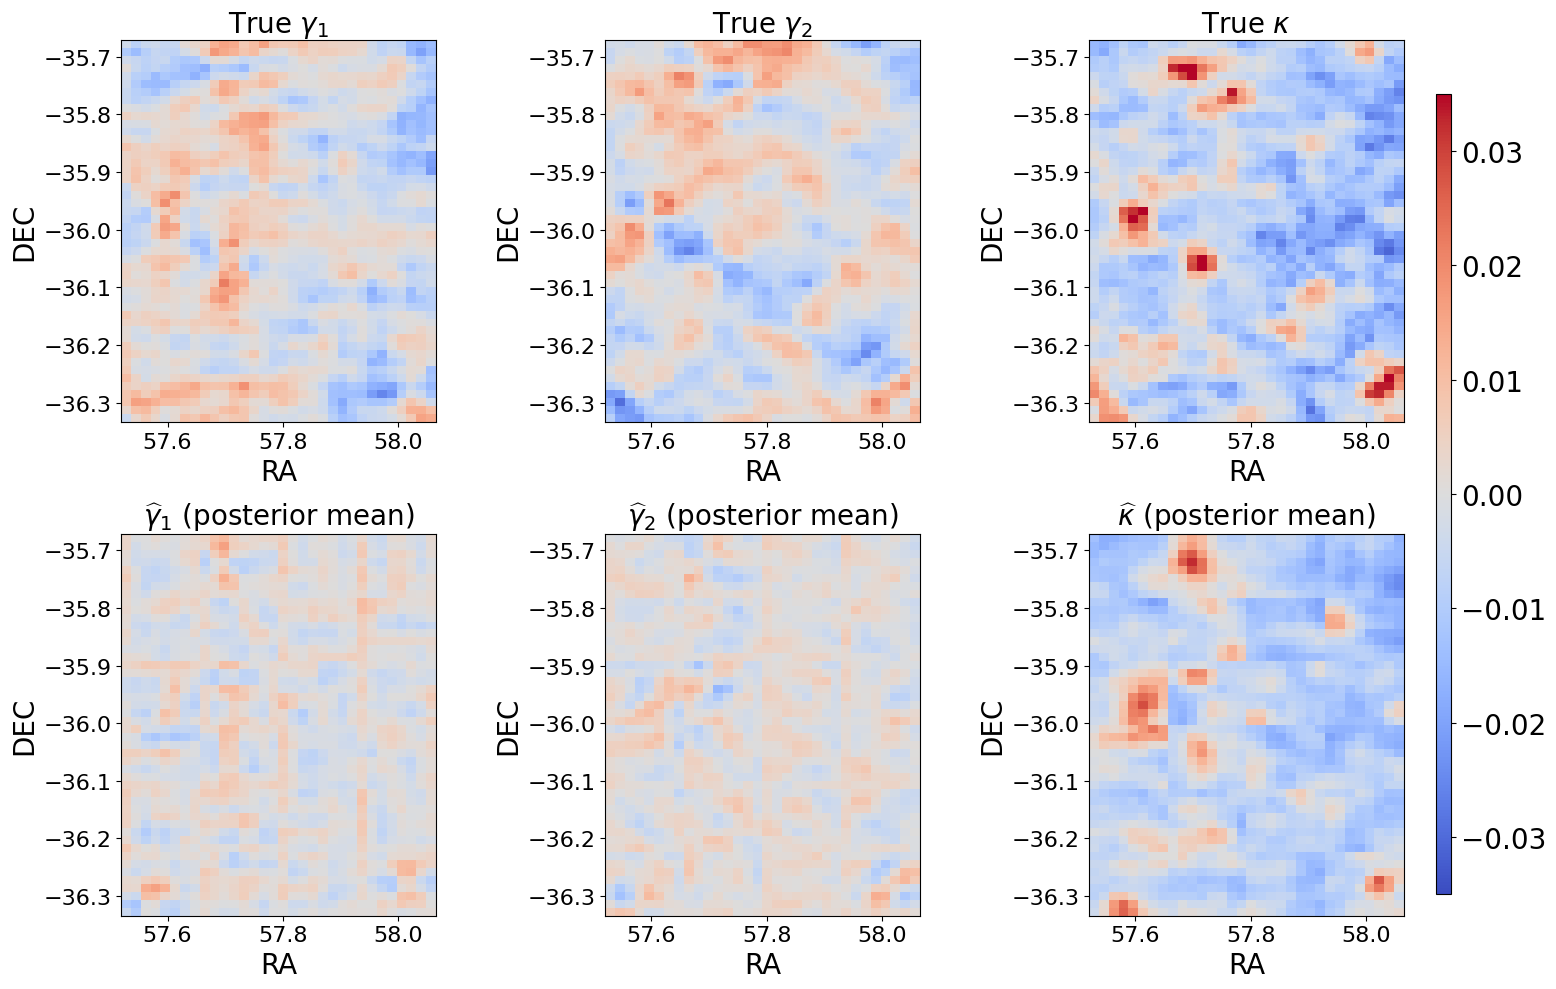

In [17]:
fig, ax = plt.subplots(2, 3, figsize = (15,10))
vmin = -0.035
vmax = 0.035
fontsize = 20
ticklabelsize = 16
interpolation = 'none'

extent = [ra_subset_sorted.min().cpu(), ra_subset_sorted.max().cpu(),
          dec_subset_sorted.min().cpu(), dec_subset_sorted.max().cpu()]

_ = ax[0,0].imshow(shear1_true_subset_sorted.cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[0,0].set_title(r'True $\gamma_1$', fontsize = fontsize)


_ = ax[1,0].imshow(shear1_pred_subset_sorted.cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[1,0].set_title(r'$\widehat{\gamma}_1$ (posterior mean)', fontsize = fontsize)

_ = ax[0,1].imshow(shear2_true_subset_sorted.cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[0,1].set_title(r'True $\gamma_2$', fontsize = fontsize)
_ = ax[1,1].imshow(shear2_pred_subset_sorted.cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[1,1].set_title(r'$\widehat{\gamma}_2$ (posterior mean)', fontsize = fontsize)

_ = ax[0,2].imshow(convergence_true_subset_sorted.cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[0,2].set_title(r'True $\kappa$', fontsize = fontsize)
conv = ax[1,2].imshow(convergence_pred_subset_sorted.cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[1,2].set_title(r'$\widehat{\kappa}$ (posterior mean)', fontsize = fontsize)


fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.1, 0.01, 0.8])
cbar_ax.tick_params(labelsize = fontsize)
fig.colorbar(conv, cax=cbar_ax)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.01)

for a in ax.flat:
    a.tick_params(axis='both', which='major', labelsize=ticklabelsize)
    a.set_xlabel('RA', fontsize = fontsize)
    a.set_ylabel('DEC', fontsize = fontsize)

_ = fig.tight_layout()

fig.savefig("figures/posteriormeanmaps_contiguous.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)